# DNN (6주차)

SEOYEON CHOI  
2022-10-12

기계학습 특강 (6주차) 10월5일 \[딥러닝의 기초 - 깊은신경망(2)–
시벤코정리, 신경망의표현, CPU vs GPU, 확률적경사하강법, 오버피팅\]

## imports

In [198]:
import torch
import torchvision
from fastai.data.all import *
import matplotlib.pyplot as plt

In [199]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }');

In [200]:
#hide
graphviz.set_jupyter_format('png')

'png'

------------------------------------------------------------------------

## 시벤코정리

### 지난시간 논리전개

`-` 아이디어: linear -\> relu -\> linear (-\> sigmoid) 조합으로
꺽은선으로 표현되는 underlying 을 표현할 수 있었다. - 아이디어의 실용성:
실제자료에서 꺾은선으로 표현되는 underlying은 몇개 없을 것 같음. 그건
맞는데 꺾이는 점을 많이 설정하면 얼추 비슷하게는 “근사” 시킬 수 있음. -
아이디어의 확장성: 이러한 논리전개는 X:(n,2)인 경우도 가능했음. (이 경우
꺾인선은 꺾인평면이 된다) - 아이디어에 해당하는 용어정리: 이 구조가
x-\>y 로 바로 가는 것이 아니라 x-\>(u1-\>v1)-\>(u2-\>v2)=y 의 구조인데
이러한 네트워크를 하나의 은닉층을 포함하는 네트워크라고 표현한다. (이
용어는 이따가..)

### 시벤코정리

**universal approximation thm: (범용근사정리,보편근사정리,시벤코정리)**,
1989

> 하나의 은닉층을 가지는 “linear -\> sigmoid -\> linear” 꼴의 네트워크를
> 이용하여 세상에 존재하는 모든 (다차원) 연속함수를 원하는 정확도로
> 근사시킬 수 있다. (계수를 잘 추정한다면)

`-` 사실 엄청 이해안되는 정리임. 왜냐햐면, - 그렇게 잘 맞추면 1989년에
세상의 모든 문제를 다 풀어야 한거 아니야? - 요즘은 “linear -\> sigmoid
-\> linear” 가 아니라 “linear -\> relu -\> linear” 조합으로 많이
쓰던데? - 요즘은 하나의 은닉층을 포함하는 네트워크는 잘 안쓰지 않나?
은닉층이 여러개일수록 좋다고 어디서 본 것 같은데?

`-` 약간의 의구심이 있지만 아무튼 universal approximation thm에 따르면
우리는 아래와 같은 무기를 가진 꼴이 된다. - 우리의 무기:
${\bf X}: (n,p)$ 꼴의 입력에서 ${\bf y}:(n,1)$ 꼴의 출력으로 향하는
맵핑을 “linear -\> relu -\> linear”와 같은 네트워크를 이용해서
“근사”시킬 수 있다.

(서연 필기) 한 층만 있어도 노드가 충분히 크면 은닉층 한 층으로 충분히
맞출 수 있다.

## 시벤코정리 proof

### 그림으로 보는 증명과정

`-` 데이터

In [201]:
x = torch.linspace(-10,10,200).reshape(-1,1)

`-` 아래와 같은 네트워크를 고려하자.

In [202]:
l1 = torch.nn.Linear(in_features=1,out_features=2)
a1 = torch.nn.Sigmoid()
l2 = torch.nn.Linear(in_features=2,out_features=1)

`-` 직관1: $l_1$,$l_2$의 가중치를 잘 결합하다보면 우연히 아래와 같이
만들 수 있다.

In [203]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+10.00,+10.00])

In [204]:
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])

Text(0.5, 1.0, '$(l_2 \\circ a_1 \\circ \\l_1)(x)$')

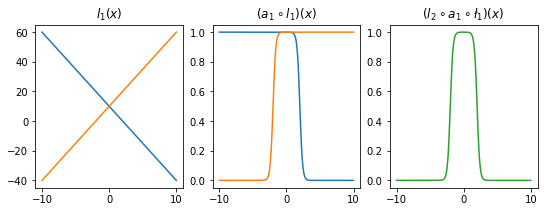

In [205]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,color='C2'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$')

`-` 직관2: 아래들도 가능할듯?

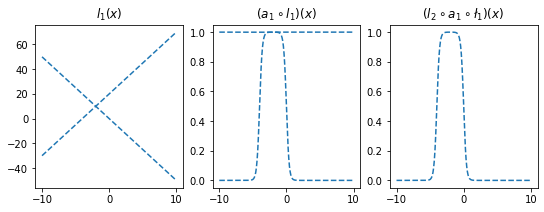

In [206]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+0.00,+20.00])
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data,'--',color='C0'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data,'--',color='C0'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C0'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');

(서연 필기) 밑에 fig 다시 정의 안 해줬잖아. 그러니까 덮어쓴 거라
생각하면 돼

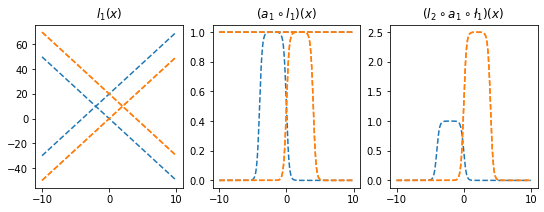

In [215]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+20.00,+0.00])
l2.weight.data = torch.tensor([[2.50,2.50]])
l2.bias.data = torch.tensor([-2.50])
ax[0].plot(x,l1(x).data,'--',color='C1'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data,'--',color='C1'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C1'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');
fig

`-` `은닉층의노드수=4`로 하고 적당한 가중치를 조정하면
$(l_2\circ a_1 \circ l_1)(x)$의 결과로 주황색선 + 파란색선도 가능할 것
같다. $\to$ 실제로 가능함

In [216]:
l1 = torch.nn.Linear(in_features=1,out_features=4)
a1 = torch.nn.Sigmoid()
l2 = torch.nn.Linear(in_features=4,out_features=1)

In [217]:
l1.weight.data = torch.tensor([[-5.00],[5.00],[-5.00],[5.00]])
l1.bias.data = torch.tensor([0.00, 20.00, 20.00, 0])
l2.weight.data = torch.tensor([[1.00,  1.00, 2.50,  2.50]])
l2.bias.data = torch.tensor([-1.0-2.5])

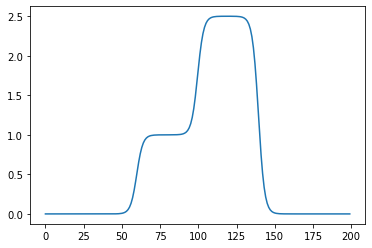

In [218]:
plt.plot(l2(a1(l1(x))).data)

`-` 2개의 시그모이드를 우연히 잘 결합하면 아래와 같은 함수 $h$를 만들 수
있다.

In [219]:
h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0

Text(0.5, 1.0, '$h(x)$')

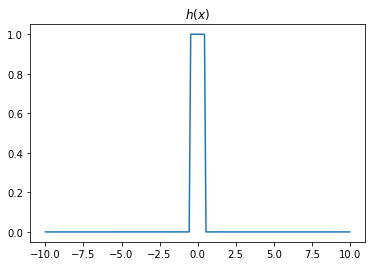

In [220]:
plt.plot(x,h(x))
plt.title("$h(x)$")

`-` 위와 같은 함수 $h$를 활성화함수로 하고 $m$개의 노드를 가지는
은닉층을 생각해보자. 이러한 은닉층을 사용한다면 전체 네트워크를 아래와
같이 표현할 수 있다.

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

그리고 위의 네트워크와 동일한 효과를 주는 아래의 네트워크가 항상 존재함.

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,2m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

`-` $h(x)$를 활성화함수로 가지는 네트워크를 설계하여 보자.

In [221]:
class MyActivation(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__() 
    def forward(self, input):
        return h(input) # activation 의 출력 

forward 순전파

backward 역전파

In [222]:
a1=MyActivation()
# a1 = torch.nn.Sigmoid(), a1 = torch.nn.ReLU() 대신에 a1 = MyActivation()

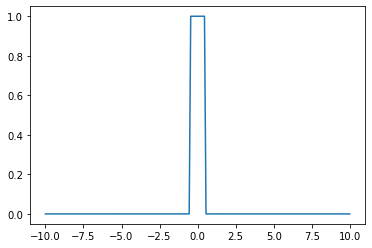

In [223]:
plt.plot(x,a1(x)) 

**히든레이어가 1개의 노드를 가지는 경우**

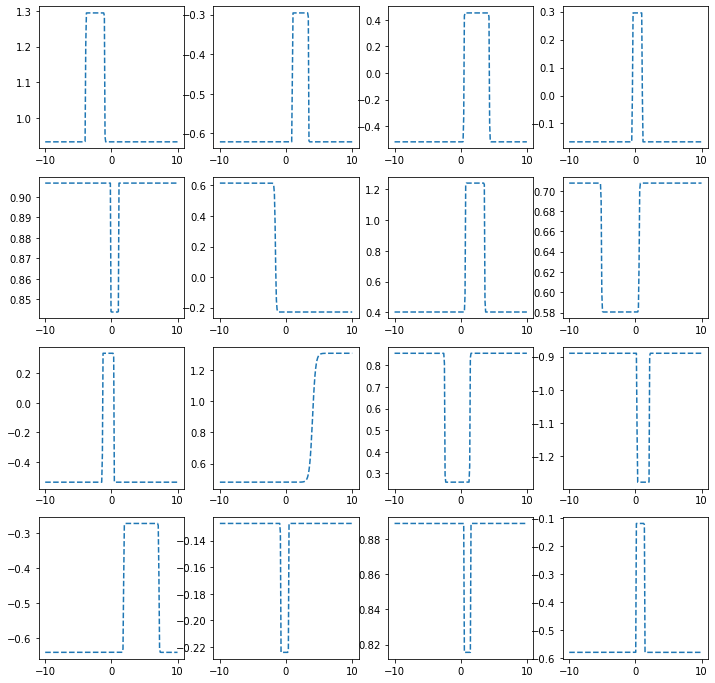

In [224]:
torch.manual_seed(43052)
fig, ax = plt.subplots(4,4,figsize=(12,12))
for i in range(4):
    for j in range(4):
        net = torch.nn.Sequential(
            torch.nn.Linear(1,1),
            MyActivation(),
            torch.nn.Linear(1,1)
        )
        ax[i,j].plot(x,net(x).data,'--')

**히든레이어가 2개의 노드를 가지는 경우**

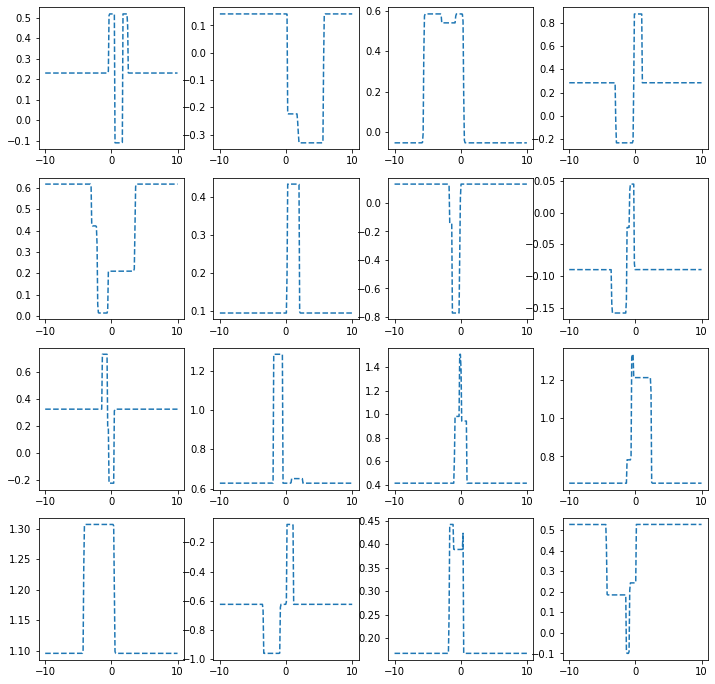

In [225]:
torch.manual_seed(43052)
fig, ax = plt.subplots(4,4,figsize=(12,12))
for i in range(4):
    for j in range(4):
        net = torch.nn.Sequential(
            torch.nn.Linear(1,2),
            MyActivation(),
            torch.nn.Linear(2,1)
        )
        ax[i,j].plot(x,net(x).data,'--')

**히든레이어가 3개의 노드를 가지는 경우**

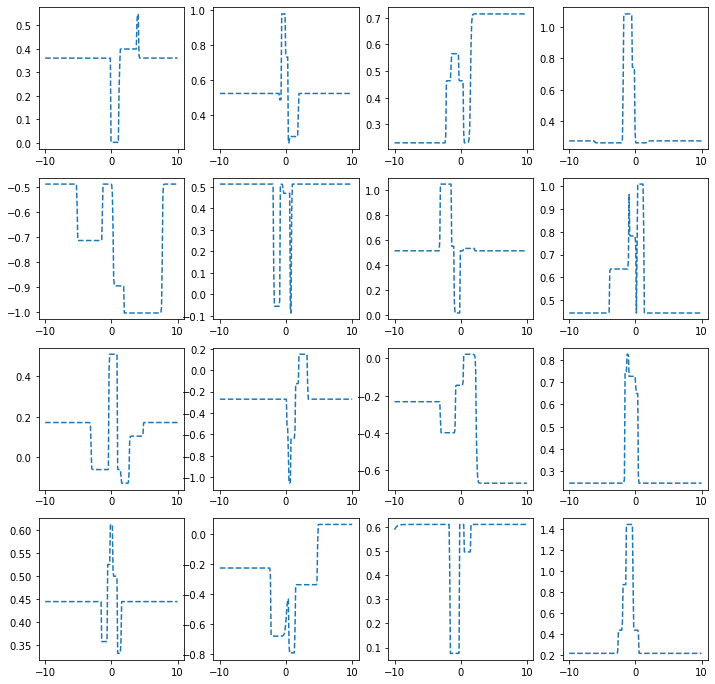

In [226]:
torch.manual_seed(43052)
fig, ax = plt.subplots(4,4,figsize=(12,12))
for i in range(4):
    for j in range(4):
        net = torch.nn.Sequential(
            torch.nn.Linear(1,3),
            MyActivation(),
            torch.nn.Linear(3,1)
        )
        ax[i,j].plot(x,net(x).data,'--')

**히든레이어가 1024개의 노드를 가지는 경우**

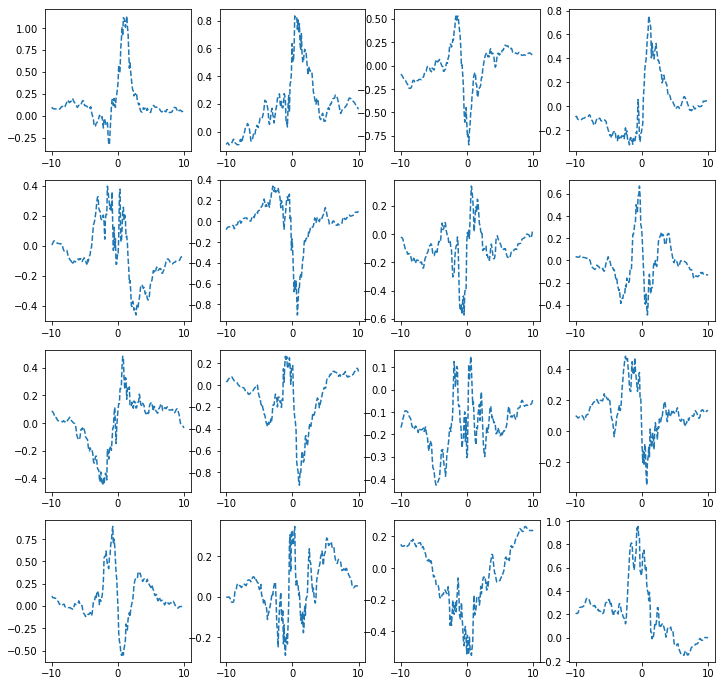

In [227]:
torch.manual_seed(43052)
fig, ax = plt.subplots(4,4,figsize=(12,12))
for i in range(4):
    for j in range(4):
        net = torch.nn.Sequential(
            torch.nn.Linear(1,1024),
            MyActivation(),
            torch.nn.Linear(1024,1)
        )
        ax[i,j].plot(x,net(x).data,'--')

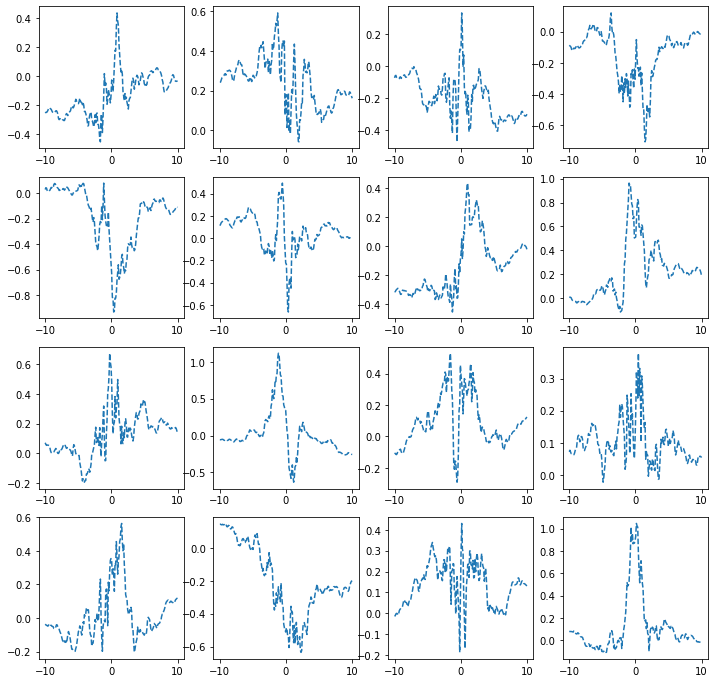

In [228]:
torch.manual_seed(43052)
fig, ax = plt.subplots(4,4,figsize=(12,12))
for i in range(4):
    for j in range(4):
        net = torch.nn.Sequential(
            torch.nn.Linear(1,2048),
            MyActivation(),
            torch.nn.Linear(2048,1)
        )
        ax[i,j].plot(x,net(x).data,'--')

## 시벤코정리 활용

`-` 아래와 같이 하나의 은닉층을 가지고 있더라도 많은 노드수만 보장되면
매우 충분한 표현력을 가짐

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

### 예제1 (sin, exp)

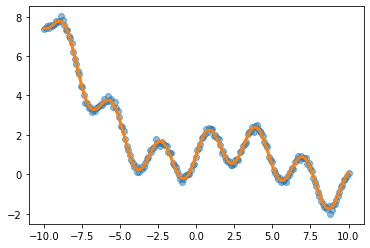

In [229]:
torch.manual_seed(43052)
x = torch.linspace(-10,10,200).reshape(-1,1)
underlying = torch.sin(2*x) + torch.sin(0.5*x) + torch.exp(-0.2*x)
eps = torch.randn(200).reshape(-1,1)*0.1
y = underlying + eps 
plt.plot(x,y,'o',alpha=0.5)
plt.plot(x,underlying,lw=3)

In [230]:
h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
class MyActivation(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__() 
    def forward(self, input):
        return h(input) 

In [231]:
net= torch.nn.Sequential(
    torch.nn.Linear(1,2048),
    MyActivation(),
    torch.nn.Linear(2048,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters()) 

mseloss쓴 거 확인

In [232]:
for epoc in range(200):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

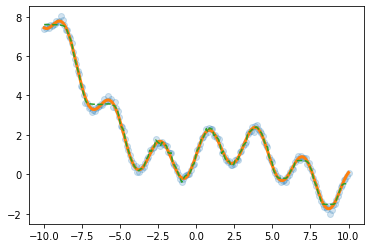

In [233]:
plt.plot(x,y,'o',alpha=0.2)
plt.plot(x,underlying,lw=3)
plt.plot(x,net(x).data,'--')

### 예제2 (스펙높아도 취업X)

In [234]:
df=pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex0.csv')
df

2000 rows × 3 columns

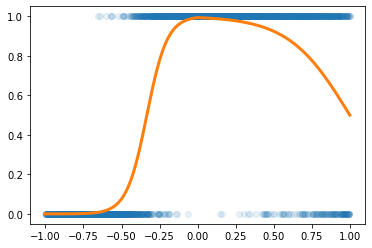

In [235]:
x = torch.tensor(df.x).reshape(-1,1).float()
y = torch.tensor(df.y).reshape(-1,1).float()
plt.plot(x,y,'o',alpha=0.1)
plt.plot(df.x,df.underlying,lw=3)

In [236]:
h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
class MyActivation(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__() 
    def forward(self, input):
        return h(input) 

In [237]:
torch.manual_seed(43052)
net= torch.nn.Sequential(
    torch.nn.Linear(1,2048),
    MyActivation(),
    torch.nn.Linear(2048,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters()) 

BCEloss쓴 거 확인

In [238]:
for epoc in range(100):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

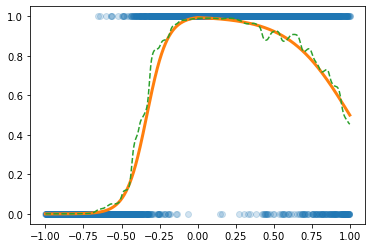

In [239]:
plt.plot(x,y,'o',alpha=0.2)
plt.plot(df.x,df.underlying,lw=3)
plt.plot(x,net(x).data,'--')

### 예제3 (MNIST data with DNN)

#### `#` 예비학습

**(예비학습1) Path**

In [240]:
path = untar_data(URLs.MNIST) 
path

Path('/home/csy/.fastai/data/mnist_png')

-   path 도 오브젝트임
-   path 도 정보+기능이 있음

`-` path의 정보

In [241]:
path._str # 숨겨놓았네?

'/home/csy/.fastai/data/mnist_png'

`-` 기능1

path는 객체,

In [242]:
path.ls()

(#2) [Path('/home/csy/.fastai/data/mnist_png/training'),Path('/home/csy/.fastai/data/mnist_png/testing')]

path object의 list 보여주는 역할

`-` 기능2

In [243]:
path/'training'

Path('/home/csy/.fastai/data/mnist_png/training')

In [244]:
path/'testing'

Path('/home/csy/.fastai/data/mnist_png/testing')

`-` 기능1과 기능2의 결합

In [245]:
(path/'training/3').ls()

(#6131) [Path('/home/csy/.fastai/data/mnist_png/training/3/35407.png'),Path('/home/csy/.fastai/data/mnist_png/training/3/26671.png'),Path('/home/csy/.fastai/data/mnist_png/training/3/16171.png'),Path('/home/csy/.fastai/data/mnist_png/training/3/15346.png'),Path('/home/csy/.fastai/data/mnist_png/training/3/34710.png'),Path('/home/csy/.fastai/data/mnist_png/training/3/48873.png'),Path('/home/csy/.fastai/data/mnist_png/training/3/28796.png'),Path('/home/csy/.fastai/data/mnist_png/training/3/15651.png'),Path('/home/csy/.fastai/data/mnist_png/training/3/6894.png'),Path('/home/csy/.fastai/data/mnist_png/training/3/37927.png')...]

In [246]:
! ls /home/csy/.fastai/data/mnist_png

testing  training

In [247]:
! ls /home/csy/.fastai/data/mnist_png/training

0  1  2  3  4  5  6  7  8  9

In [248]:
! ls /home/csy/.fastai/data/mnist_png/testing

0  1  2  3  4  5  6  7  8  9

-   ‘/home/cgb4/.fastai/data/mnist_png/training/3/37912.png’ 이 파일을
    더블클릭하면 이미지가 보인단 말임

**(예비학습2)** plt.imshow

In [249]:
imgtsr = torch.tensor([[1.0,2],[2.0,4.0]])
imgtsr

tensor([[1., 2.],
        [2., 4.]])

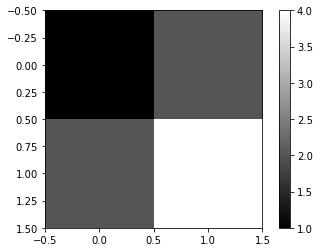

In [250]:
plt.imshow(imgtsr,cmap='gray')
plt.colorbar()

In [251]:
imgtsr = torch.tensor([0.1,0.2,0.3,0.4]).reshape(2,2)
imgtsr

tensor([[0.1000, 0.2000],
        [0.3000, 0.4000]])

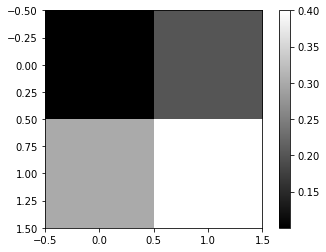

In [252]:
plt.imshow(imgtsr,cmap='gray')
plt.colorbar()

**(예비학습3)** torchvision

`-` ’/home/cgb4/.fastai/data/mnist_png/training/3/37912.png’의
이미지파일을 torchvision.io.read_image 를 이용하여 텐서로 만듬

``` python
!ls '/home/csy/.fastai/data/mnist_png/training/3'
```

In [253]:
imgtsr = torchvision.io.read_image('/home/csy/.fastai/data/mnist_png/training/3/37912.png')
imgtsr

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  17,  66, 138,
          149, 180, 138, 138,  86,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

`-` 이 텐서는 (1,28,28)의 shape을 가짐

In [254]:
imgtsr.shape

torch.Size([1, 28, 28])

`-` imgtsr를 plt.imshow 로 시각화

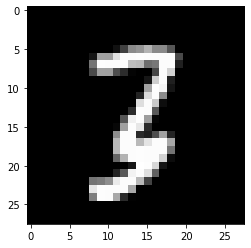

In [255]:
plt.imshow(imgtsr.reshape(28,28),cmap='gray')

-   진짜 숫자3이 있음

#### `#` 데이터정리

`-` 데이터정리

In [264]:
threes_fnames = (path/'training/3').ls()
sevens_fnames = (path/'training/7').ls()
len(threes_fnames),len(sevens_fnames)

(6131, 6265)

-   6131, 1, 28, 28
-   6265, 1, 28, 28

In [272]:
torch.stack([torchvision.io.read_image(str(threes_fnames[i])) for i in [0,1]]).shape

torch.Size([2, 1, 28, 28])

In [285]:
torch.stack([torchvision.io.read_image(str(fn)) for fn in threes_fnames]).shape

torch.Size([6131, 1, 28, 28])

In [287]:
torch.stack([torchvision.io.read_image(str(fn)) for fn in sevens_fnames]).shape

torch.Size([6265, 1, 28, 28])

In [273]:
X3 = torch.stack([torchvision.io.read_image(str(threes_fnames[i])) for i in range(6131)])
X7 = torch.stack([torchvision.io.read_image(str(sevens_fnames[i])) for i in range(6265)])

In [274]:
X3.shape,X7.shape

(torch.Size([6131, 1, 28, 28]), torch.Size([6265, 1, 28, 28]))

In [275]:
len(threes_fnames) + len(sevens_fnames)

12396

In [276]:
X=torch.concat([X3,X7])
X.shape

torch.Size([12396, 1, 28, 28])

In [289]:
Xnp = X.reshape(-1,1*28*28).float() # Xnp = X.reshape(-1,784).float()
Xnp.shape

torch.Size([12396, 784])

$\star$ float형으로 바꿔주기

In [278]:
y = torch.tensor([0.0]*6131 + [1.0]*6265).reshape(-1,1) 
y.shape

torch.Size([12396, 1])

In [288]:
y = torch.tensor([0.0]*len(threes_fnames) + [1.0]*len(sevens_fnames)).reshape(-1,1) 
y.shape

torch.Size([12396, 1])

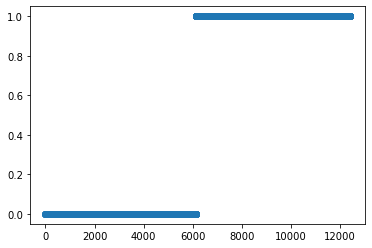

In [279]:
plt.plot(y,'o')

-   “y=0”은 숫자3을 의미, “y=1”은 숫자7을 의미
-   숫자3은 6131개, 숫자7은 6265개 있음

#### `#` 학습

`-` 네트워크의 설계

In [298]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1*28*28,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)

-   $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,30)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,30)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [299]:
loss_fn = torch.nn.BCELoss()

In [300]:
optimizr = torch.optim.Adam(net.parameters())

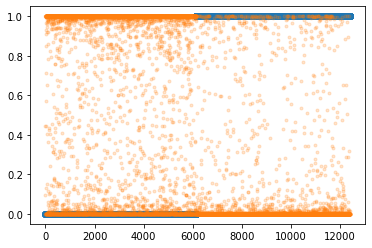

In [301]:
plt.plot(y,'o')
plt.plot(net(Xnp).data,'.',alpha=0.2)

In [302]:
for epoc in range(200):
    ## 1
    yhat = net(Xnp) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

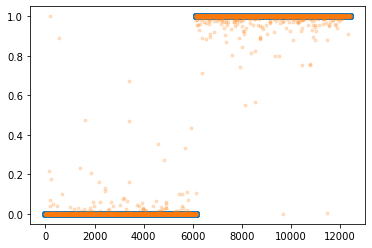

In [303]:
plt.plot(y,'o')
plt.plot(net(Xnp).data,'.',alpha=0.2)

-   대부분 잘 적합되었음

## 신경망의 표현 (${\boldsymbol x} \to \hat{\boldsymbol y}$ 로 가는 과정을 그림으로 표현)

### 예제1: $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(1)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 모든 observation과 가중치를 명시한 버전

**(표현1)**

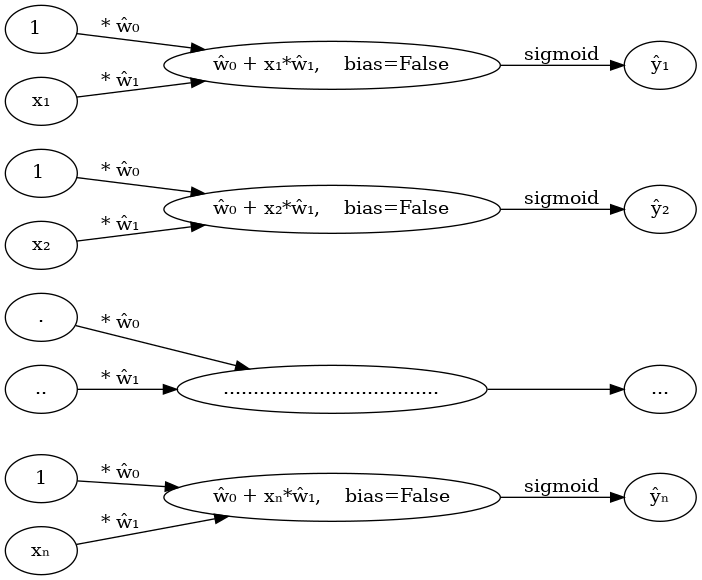

In [304]:
#collapse
gv(''' 
    "1" -> "ŵ₀ + xₙ*ŵ₁,    bias=False"[label="* ŵ₀"]
    "xₙ" -> "ŵ₀ + xₙ*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + xₙ*ŵ₁,    bias=False" -> "ŷₙ"[label="sigmoid"]

    "." -> "...................................."[label="* ŵ₀"]
    ".." -> "...................................."[label="* ŵ₁"]
    "...................................." -> "..."[label=" "]

    "1 " -> "ŵ₀ + x₂*ŵ₁,    bias=False"[label="* ŵ₀"]
    "x₂" -> "ŵ₀ + x₂*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + x₂*ŵ₁,    bias=False" -> "ŷ₂"[label="sigmoid"]
    
    "1  " -> "ŵ₀ + x₁*ŵ₁,    bias=False"[label="* ŵ₀"]
    "x₁" -> "ŵ₀ + x₁*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + x₁*ŵ₁,    bias=False" -> "ŷ₁"[label="sigmoid"]
''')

-   단점: 똑같은 그림의 반복이 너무 많음

`-` observation 반복을 생략한 버전들

**(표현2)** 모든 $i$에 대하여 아래의 그림을 반복한다고 하면 (표현1)과
같다.

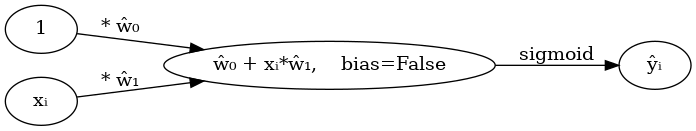

In [305]:
#collapse
gv(''' 
    "1" -> "ŵ₀ + xᵢ*ŵ₁,    bias=False"[label="* ŵ₀"]
    "xᵢ" -> "ŵ₀ + xᵢ*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + xᵢ*ŵ₁,    bias=False" -> "ŷᵢ"[label="sigmoid"]

''')


**(표현3)** 그런데 (표현2)에서 아래와 같이 $x_i$, $y_i$ 대신에 간단히
$x$, $y$로 쓰는 경우도 많음

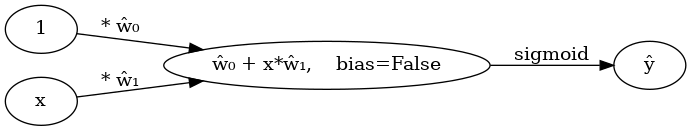

In [306]:
#collapse
gv(''' 
    "1" -> "ŵ₀ + x*ŵ₁,    bias=False"[label="* ŵ₀"]
    "x" -> "ŵ₀ + x*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + x*ŵ₁,    bias=False" -> "ŷ"[label="sigmoid"]

''')


`-` 1을 생략한 버전들

**(표현4)** bais=False 대신에 bias=True를 주면 1을 생략할 수 있음

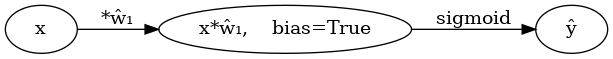

In [307]:
#collapse
gv('''
"x" -> "x*ŵ₁,    bias=True"[label="*ŵ₁"] ;
"x*ŵ₁,    bias=True" -> "ŷ"[label="sigmoid"] ''')


**(표현4의 수정)** $\hat{w}_1$대신에 $\hat{w}$를 쓰는 것이 더 자연스러움

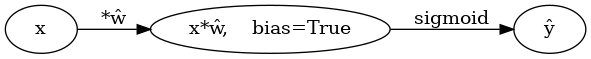

In [308]:
#collapse
gv('''
"x" -> "x*ŵ,    bias=True"[label="*ŵ"] ;
"x*ŵ,    bias=True" -> "ŷ"[label="sigmoid"] ''')


**(표현5)** 선형변환의 결과는 아래와 같이 $u$로 표현하기도 한다.

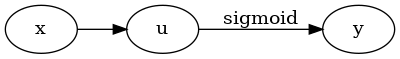

In [309]:
#collapse
gv('''
"x" -> "u";
"u" -> "y"[label="sigmoid"] ''')


> 다이어그램은 그리는 사람의 취향에 따라 그리는 방법이 조금씩 다릅니다.
> 즉 교재마다 달라요.

### 예제2: $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$

**참고: 코드로 표현**

``` python
torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Sigmoid()
)
```

`-` 이해를 위해서 10월4일 강의노트에서 다루었던 아래의 상황을 고려하자.

![](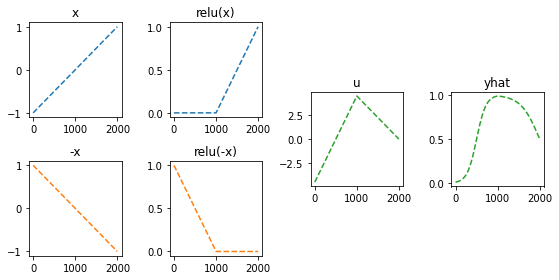%0A.png)

**(강의노트의 표현)**

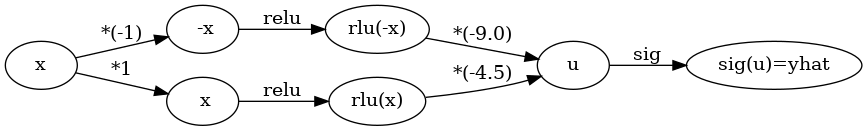

In [310]:
#collapse
gv('''
"x" -> " -x"[label="*(-1)"];
"x" -> " x"[label="*1"]
" x" -> "rlu(x)"[label="relu"] 
" -x" -> "rlu(-x)"[label="relu"] 
"rlu(x)" -> "u"[label="*(-4.5)"] 
"rlu(-x)" -> "u"[label="*(-9.0)"] 
"u" -> "sig(u)=yhat"[label="sig"] 
'''
)

**(좀 더 일반화된 표현)** 10월4일 강의노트 상황을 일반화하면 아래와
같다.

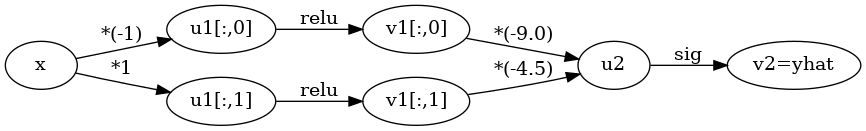

In [311]:
#collapse
gv('''
"x" -> "u1[:,0]"[label="*(-1)"];
"x" -> "u1[:,1]"[label="*1"]
"u1[:,0]" -> "v1[:,0]"[label="relu"] 
"u1[:,1]" -> "v1[:,1]"[label="relu"] 
"v1[:,0]" -> "u2"[label="*(-9.0)"] 
"v1[:,1]" -> "u2"[label="*(-4.5)"] 
"u2" -> "v2=yhat"[label="sig"] 
'''
)

`*` Layer의 개념: ${\bf X}$에서 $\hat{\boldsymbol y}$로 가는 과정은
“선형변환+비선형변환”이 반복되는 구조이다. “선형변환+비선형변환”을
하나의 세트로 보면 아래와 같이 표현할 수 있다.

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \left( \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \right) \overset{l_2}{\to} \left(\underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}\right), \quad \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{net({\bf X})}=\underset{(n,1)}{\hat{\boldsymbol y}}$

이것을 다이어그램으로 표현한다면 아래와 같다.

**(선형+비선형을 하나의 Layer로 묶은 표현)**

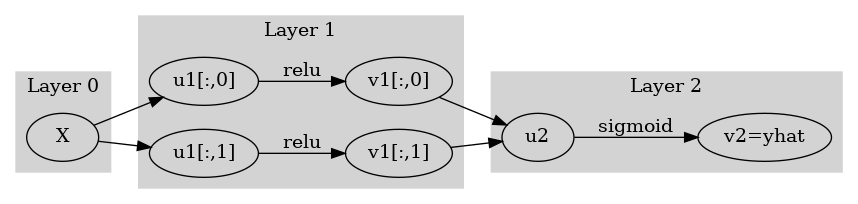

In [312]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "u1[:,0]"
    "X" -> "u1[:,1]"
    "u1[:,0]" -> "v1[:,0]"[label="relu"]
    "u1[:,1]" -> "v1[:,1]"[label="relu"]
    label = "Layer 1"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "v1[:,0]" -> "u2"
    "v1[:,1]" -> "u2"
    "u2" -> "v2=yhat"[label="sigmoid"]
    label = "Layer 2"
}
''')

***Layer를 세는 방법*** - 정석: **학습가능한 파라메터**가 몇층으로
있는지… - 일부 교재 설명: 입력층은 계산하지 않음, activation layer는
계산하지 않음. - 위의 예제의 경우 `number of layer = 2` 이다.

> 사실 input layer, activation layer 등의 표현을 자주 사용해서 layer를
> 세는 방법이 처음에는 헷갈립니다..

***Hidden Layer의 수를 세는 방법*** -
`Layer의 수 = Hidden Layer의 수 + 출력층의 수 = Hidden Layer의 수 + 1` -
위의 예제의 경우 `number of hidden layer = 1` 이다.

`*` node의 개념: $u\to v$로 가는 쌍을 간단히 노드라는 개념을 이용하여
나타낼 수 있음.

**(노드의 개념이 포함된 그림)**

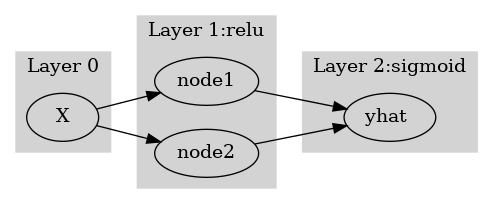

In [313]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "node1"
    "X" -> "node2"
    label = "Layer 1:relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "yhat "
    "node2" -> "yhat "
    label = "Layer 2:sigmoid"
}
''')

여기에서 `node의 숫자 = feature의 숫자`와 같이 이해할 수 있다. 즉 아래와
같이 이해할 수 있다.

**(“number of nodes = number of features”로 이해한 그림)**

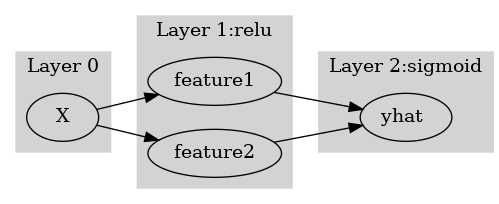

In [314]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "feature1"
    "X" -> "feature2"
    label = "Layer 1:relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "feature1" -> "yhat "
    "feature2" -> "yhat "
    label = "Layer 2:sigmoid"
}
''')

> 다이어그램의 표현방식은 교재마다 달라서 모든 예시를 달달 외울 필요는
> 없습니다. 다만 임의의 다이어그램을 보고 대응하는 네트워크를 pytorch로
> 구현하는 능력은 매우 중요합니다.

### 예제3: $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

**(다이어그램표현)**

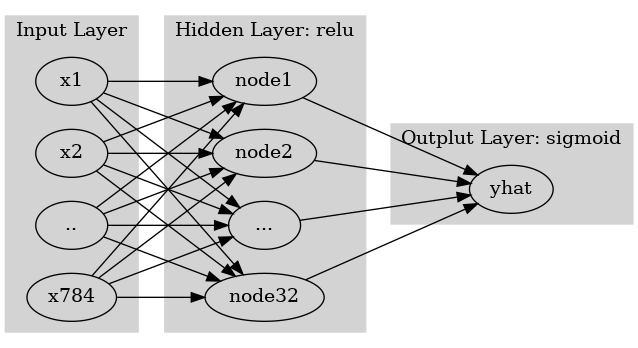

In [315]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Input Layer"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node32"
    "x2" -> "node32"
    ".." -> "node32"
    "x784" -> "node32"


    label = "Hidden Layer: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;

    "node1" -> "yhat"
    "node2" -> "yhat"
    "..." -> "yhat"
    "node32" -> "yhat"
    
    label = "Outplut Layer: sigmoid"
}
''')

-   Layer0,1,2 대신에 Input Layer, Hidden Layer, Output Layer로 표현함

`-` 위의 다이어그램에 대응하는 코드

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=28*28*1,out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1),
    torch.nn.Sigmoid() 
)
```

## CPU vs GPU

`-` 파이토치에서 GPU를 쓰는 방법을 알아보자. (사실 지금까지 우리는 CPU만
쓰고 있었음)

### GPU 사용방법

`-` cpu 연산이 가능한 메모리에 데이터 저장

In [325]:
torch.manual_seed(43052)
x_cpu = torch.tensor([0.0,0.1,0.2]).reshape(-1,1) 
y_cpu = torch.tensor([0.0,0.2,0.4]).reshape(-1,1) 
net_cpu = torch.nn.Linear(1,1) 

연산되게끔 reshape으로 shape 변경해주세요

In [349]:
x_cpu, y_cpu

(tensor([[0.0000],
         [0.1000],
         [0.2000]]),
 tensor([[0.0000],
         [0.2000],
         [0.4000]]))

In [327]:
net_cpu.weight, net_cpu.bias

(Parameter containing:
 tensor([[-0.3467]], requires_grad=True),
 Parameter containing:
 tensor([-0.8470], requires_grad=True))

`-` gpu 연산이 가능한 메모리에 데이터 저장

In [328]:
torch.manual_seed(43052)
x_gpu = x_cpu.to("cuda:0")
y_gpu = y_cpu.to("cuda:0")
net_gpu = torch.nn.Linear(1,1).to("cuda:0") 

cpu있는 자체는 못 넣고

``` python
net_gpu = net_cpu.to("cuda:0")
```

cpu에 있는 net을 가져와서 정의해줘야 한다.

------------------------------------------------------------------------

In [337]:
_a = torch.nn.Linear(1,1)

In [338]:
_a.weight, _a.bias

(Parameter containing:
 tensor([[0.4074]], requires_grad=True),
 Parameter containing:
 tensor([-0.8885], requires_grad=True))

In [339]:
_a.to("cuda:0") 

Linear(in_features=1, out_features=1, bias=True)

In [340]:
_a.weight, _a.bias

(Parameter containing:
 tensor([[0.4074]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.8885], device='cuda:0', requires_grad=True))

------------------------------------------------------------------------

In [341]:
x_gpu, y_gpu

(tensor([[0.0000],
         [0.1000],
         [0.2000]], device='cuda:0'),
 tensor([[0.0000],
         [0.2000],
         [0.4000]], device='cuda:0'))

In [342]:
net_gpu.weight, net_gpu.bias

(Parameter containing:
 tensor([[-0.3467]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.8470], device='cuda:0', requires_grad=True))

`-` cpu 혹은 gpu 연산이 가능한 메모리에 저장된 값들을 확인

In [343]:
x_cpu, y_cpu, net_cpu.weight, net_cpu.bias

(tensor([[0.0000],
         [0.1000],
         [0.2000]]),
 tensor([[0.0000],
         [0.2000],
         [0.4000]]),
 Parameter containing:
 tensor([[-0.3467]], requires_grad=True),
 Parameter containing:
 tensor([-0.8470], requires_grad=True))

In [344]:
x_gpu, y_gpu, net_gpu.weight, net_gpu.bias

(tensor([[0.0000],
         [0.1000],
         [0.2000]], device='cuda:0'),
 tensor([[0.0000],
         [0.2000],
         [0.4000]], device='cuda:0'),
 Parameter containing:
 tensor([[-0.3467]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.8470], device='cuda:0', requires_grad=True))

`-` gpu는 gpu끼리 연산가능하고 cpu는 cpu끼리 연산가능함

(예시1)

In [345]:
net_cpu(x_cpu) 

tensor([[-0.8470],
        [-0.8817],
        [-0.9164]], grad_fn=<AddmmBackward0>)

(예시2)

In [346]:
net_gpu(x_gpu) 

tensor([[-0.8470],
        [-0.8817],
        [-0.9163]], device='cuda:0', grad_fn=<AddmmBackward0>)

(예시3)

In [347]:
net_cpu(x_gpu) 

(예시4)

In [348]:
net_gpu(x_cpu)

(예시5)

In [350]:
torch.mean((y_cpu-net_cpu(x_cpu))**2)

tensor(1.2068, grad_fn=<MeanBackward0>)

(예시6)

In [351]:
torch.mean((y_gpu-net_gpu(x_gpu))**2)

tensor(1.2068, device='cuda:0', grad_fn=<MeanBackward0>)

(예시7)

In [352]:
torch.mean((y_gpu-net_cpu(x_cpu))**2)

(예시8)

In [353]:
torch.mean((y_cpu-net_gpu(x_gpu))**2)

둘다 cpu에 있던가 둘 다 gpu에 있던가

### 시간측정 (예비학습)

In [354]:
import time 

In [355]:
t1 = time.time()

In [356]:
t2 = time.time()

In [357]:
t2-t1

0.42019009590148926

### CPU (512)

`-` 데이터준비

In [364]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01

`-` for문 준비

In [365]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

`-` for문 + 학습시간측정

In [366]:
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

0.5373966693878174

### GPU (512)

`-` 데이터준비

In [367]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")

`-` for문돌릴준비

In [368]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

`-` for문 + 학습시간측정

In [369]:
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

1.4511945247650146

-   !! CPU가 더 빠르다?

### CPU vs GPU (20480)

`-` CPU (20480)

In [370]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01

net = torch.nn.Sequential(
    torch.nn.Linear(1,20480),
    torch.nn.ReLU(),
    torch.nn.Linear(20480,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

3.806452512741089

`-` GPU (20480)

In [371]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")

net = torch.nn.Sequential(
    torch.nn.Linear(1,20480),
    torch.nn.ReLU(),
    torch.nn.Linear(20480,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

1.308497667312622

`-` 왜 이런 차이가 나는가? 연산을 하는 주체는 코어인데 CPU는 수는 적지만
일을 잘하는 코어들을 가지고 있고 GPU는 일은 못하지만 다수의 코어를
가지고 있기 때문

### CPU vs GPU (204800)

`-` CPU (204800)

In [372]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01

net = torch.nn.Sequential(
    torch.nn.Linear(1,204800),
    torch.nn.ReLU(),
    torch.nn.Linear(204800,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

65.33969926834106

`-` GPU (204800)

In [373]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")

net = torch.nn.Sequential(
    torch.nn.Linear(1,204800),
    torch.nn.ReLU(),
    torch.nn.Linear(204800,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

2.077875852584839

In [377]:
!nvidia-smi

Wed Oct 12 21:15:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 495.46       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:65:00.0 Off |                  N/A |
|  0%   41C    P8    28W / 420W |  12812MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 확률적경사하강법, 배치, 에폭

### 좀 이상하지 않아요?

`-` 우리가 쓰는 GPU: [다나와
PC견적](http://shop.danawa.com/virtualestimate/?controller=estimateMain&methods=index&marketPlaceSeq=16) -
GPU 메모리 끽해봐야 24GB

`-` 우리가 분석하는 데이터: 빅데이터..?

`-` 데이터의 크기가 커지는순간 `X.to("cuda:0")`, `y.to("cuda:0")` 쓰면
난리나겠는걸?

In [378]:
x = torch.linspace(-10,10,100000).reshape(-1,1)
eps = torch.randn(100000).reshape(-1,1)
y = x*2 + eps 

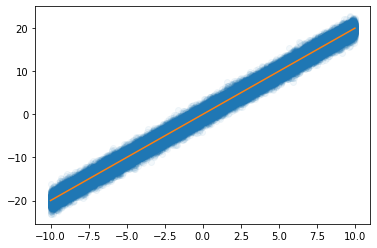

In [379]:
plt.plot(x,y,'o',alpha=0.05)
plt.plot(x,2*x)

`-` 데이터를 100개중에 1개만 꼴로만 쓰면 어떨까?

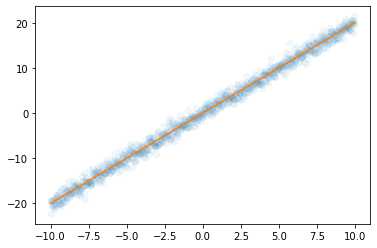

In [380]:
plt.plot(x[::100],y[::100],'o',alpha=0.05)
plt.plot(x,2*x)

-   대충 이거만 가지고 적합해도 충분히 정확할것 같은데

### X,y 데이터를 굳이 모두 GPU에 넘겨야 하는가?

`-` 데이터셋을 짝홀로 나누어서 번갈아가면서 GPU에 올렸다 내렸다하면
안되나?

`-` 아래의 알고리즘을 생각해보자. 1. 데이터를 반으로 나눈다. 2.
짝수obs의 x,y 그리고 net의 모든 파라메터를 GPU에 올린다. 3. yhat, loss,
grad, update 수행 4. 짝수obs의 x,y를 GPU메모리에서 내린다. 그리고
홀수obs의 x,y를 GPU메모리에 올린다. 5. yhat, loss, grad, update 수행 6.
홀수obs의 x,y를 GPU메모리에서 내린다. 그리고 짝수obs의 x,y를 GPU메모리에
올린다. 7. 반복

(서연 필기) 전체 다 올리면 경사하강법 부분적으로 올리면 확률적
경사하강법

### 경사하강법, 확률적경사하강법, 미니배치 경사하강법

10개의 샘플이 있다고 가정. $\{(x_i,y_i)\}_{i=1}^{10}$

`-` ver1: 모든 샘플을 이용하여 slope 계산

(epoch1)
$loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$

(epoch2)
$loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$

…

`-` ver2: 하나의 샘플만을 이용하여 slope 계산

(epoch1) - $loss=(y_1-\beta_0-\beta_1x_1)^2 \to slope \to update$ -
$loss=(y_2-\beta_0-\beta_1x_2)^2 \to slope \to update$ - … -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \to slope \to update$

(epoch2) - $loss=(y_1-\beta_0-\beta_1x_1)^2 \to slope \to update$ -
$loss=(y_2-\beta_0-\beta_1x_2)^2 \to slope \to update$ - … -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \to slope \to update$

…

(서연 필기) 불안해 - for 문도 많이 돌아야 해.

`-` ver3: $m (\leq n)$ 개의 샘플을 이용하여 slope 계산

$m=3$이라고 하자.

(epoch1) -
$loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \to slope \to update$

(epoch2) -
$loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \to slope \to update$

…

(서연 필기) 미니배치하고 남은 것도 계산된다.

### 용어의 정리

**옛날**

`-` ver1: gradient descent, batch gradient descent

`-` ver2: stochastic gradient descent

`-` ver3: mini-batch gradient descent, mini-batch stochastic gradient
descent

**요즘**

`-` ver1: gradient descent

`-` ver2: stochastic gradient descent with batch size = 1

`-` **ver3: stochastic gradient descent** -
https://www.deeplearningbook.org/contents/optimization.html, 알고리즘
8-1 참고.

### ds, dl

`-` ds

In [381]:
x=torch.tensor(range(10)).float()#.reshape(-1,1)
y=torch.tensor([1.0]*5+[0.0]*5)#.reshape(-1,1)

In [382]:
ds=torch.utils.data.TensorDataset(x,y)
ds

In [383]:
ds.tensors # 그냥 (x,y)의 튜플

(tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]))

`-` dl

In [387]:
dl=torch.utils.data.DataLoader(ds,batch_size=3)
#set(dir(dl)) & {'__iter__'}

In [388]:
set(dir(dl)) & {'__iter__'}

{'__iter__'}

dir에 \_\_iter\_\_있으면 for문 쓰기 가능

In [389]:
for xx,yy in dl:
    print(xx,yy)

tensor([0., 1., 2.]) tensor([1., 1., 1.])
tensor([3., 4., 5.]) tensor([1., 1., 0.])
tensor([6., 7., 8.]) tensor([0., 0., 0.])
tensor([9.]) tensor([0.])

### ds, dl을 이용한 MNIST 구현

`-` 데이터정리

In [390]:
path = untar_data(URLs.MNIST)

In [391]:
zero_fnames = (path/'training/0').ls()
one_fnames = (path/'training/1').ls()

In [392]:
X0 = torch.stack([torchvision.io.read_image(str(zf)) for zf in zero_fnames])
X1 = torch.stack([torchvision.io.read_image(str(of)) for of in one_fnames])
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [393]:
X.shape,y.shape

(torch.Size([12665, 784]), torch.Size([12665, 1]))

`-` ds $\to$ dl

In [394]:
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048) 

In [395]:
12665/2048

6.18408203125

In [396]:
i = 0 
for xx,yy in dl: # 총 7번 돌아가는 for문 
    print(i)
    i=i+1

0
1
2
3
4
5
6

`-` 미니배치 안쓰는 학습

In [397]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

In [398]:
for epoc in range(70): 
    ## 1 
    yhat = net(X) 
    ## 2 
    loss= loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 

In [399]:
torch.sum((yhat>0.5) == y) / len(y) 

tensor(0.9981)

In [403]:
torch.mean(((yhat>0.5) == y)*1.0)

tensor(0.9981)

In [408]:
len(y) / 2048

6.18408203125

`-` 미니배치 쓰는 학습 (GPU 올리고 내리는 과정은 생략)

In [409]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

In [410]:
for epoc in range(10):
    for xx,yy in dl: ## 7번
        ## 1
        #yhat = net(xx)
        ## 2 
        loss = loss_fn(net(xx),yy) 
        ## 3 
        loss.backward() 
        ## 4 
        optimizr.step()
        optimizr.zero_grad()

(서연 필기)xx넣어서 학습 시키고 전체 X넣어서 확인

In [413]:
len(X)

12665

In [411]:
torch.mean(((net(X)>0.5) == y)*1.0)

tensor(0.9949)

## 오버피팅

`-` 오버피팅이란? - 위키: In mathematical modeling, overfitting is “the
production of an analysis that corresponds too closely or exactly to a
particular set of data, and may therefore fail to fit to additional data
or predict future observations reliably”. - 제 개념: 데이터를 “데이터 =
언더라잉 + 오차”라고 생각할때 우리가 데이터로부터 적합할 것은
언더라잉인데 오차항을 적합하고 있는 현상.

### 오버피팅 예시

`-` $m$이 매우 클때 아래의 네트워크 거의 무엇이든 맞출수 있다고 보면
된다.

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 그런데 종종 맞추지 말아야 할 것들도 맞춘다.

model: $y_i = (0\times x_i) + \epsilon_i$, where
$\epsilon_i \sim N(0,0.01^2)$

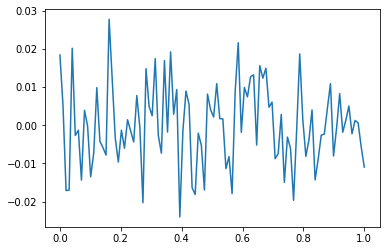

In [ ]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01
plt.plot(x,y)

-   y는 그냥 정규분포에서 생성한 오차이므로 $X \to y$ 로 항햐는
    규칙따위는 없음

In [ ]:
torch.manual_seed(1) 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

for epoc in range(1000): 
    ## 1 
    yhat=net(x) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad() 

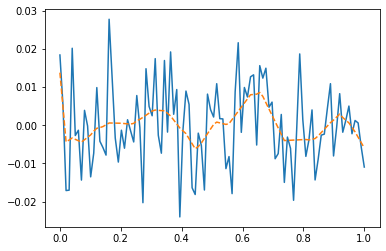

In [ ]:
plt.plot(x,y)
plt.plot(x,net(x).data,'--')

-   우리는 데이터를 랜덤에서 뽑았는데, 데이터의 추세를 따라간다 $\to$
    오버피팅 (underlying이 아니라 오차항을 따라가고 있음)

### 오버피팅이라는 뚜렷한 증거! (train / test)

`-` 데이터의 분리하여 보자.

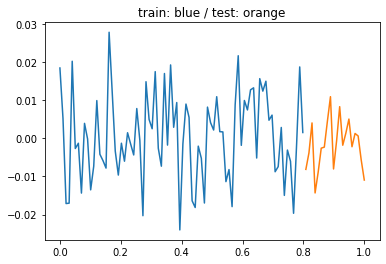

In [ ]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01
xtr = x[:80] 
ytr = y[:80]
xtest = x[80:]
ytest = y[80:]
plt.plot(xtr,ytr)
plt.plot(xtest,ytest)
plt.title('train: blue / test: orange');

`-` train만 학습

In [ ]:
torch.manual_seed(1) 
net1=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizr1= torch.optim.Adam(net1.parameters())
loss_fn= torch.nn.MSELoss()

for epoc in range(1000): 
    ## 1 
    # net(xtr) 
    ## 2 
    loss=loss_fn(net1(xtr),ytr) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr1.step()
    optimizr1.zero_grad() 

`-` training data로 학습한 net를 training data 에 적용

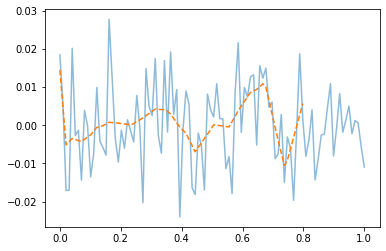

In [ ]:
plt.plot(x,y,alpha=0.5)
plt.plot(xtr,net1(xtr).data,'--') # prediction (train) 

-   train에서는 잘 맞추는듯이 보인다.

`-` training data로 학습한 net를 test data 에 적용

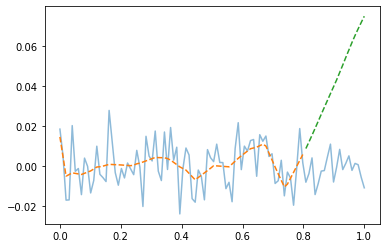

In [ ]:
plt.plot(x,y,alpha=0.5)
plt.plot(xtr,net1(xtr).data,'--') # prediction (train) 
plt.plot(xtest,net1(xtest).data,'--') # prediction with unseen data (test) 

-   train은 그럭저럭 따라가지만 test에서는 엉망이다. $\to$ overfit

## 숙제 (해설 및 풀이는 [여기](https://guebin.github.io/DL2022/2022/10/06/(6%EC%A3%BC%EC%B0%A8)-10%EC%9B%946%EC%9D%BC.html#%EC%88%99%EC%A0%9C)참고)

1.  숫자0과 숫자1을 구분하는 네트워크를 아래와 같은 구조로 설계하라

$$\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,64)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,64)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

위에서 $a_1$은 relu를, $a_2$는 sigmoid를 의미한다.

-   “y=0”은 숫자0을 의미하도록 하고 “y=1”은 숫자1을 의미하도록 설정하라.

In [700]:
path = untar_data(URLs.MNIST)

In [701]:
zero_fnames = (path/'training/0').ls()

In [702]:
one_fnames = (path/'training/1').ls()

In [703]:
X0 = torch.stack([torchvision.io.read_image(str(zf)) for zf in zero_fnames])

In [704]:
X1 = torch.stack([torchvision.io.read_image(str(of)) for of in one_fnames])

In [705]:
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28).float()

In [709]:
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [710]:
torch.manual_seed(12345)
net = torch.nn.Sequential(
    torch.nn.Linear(784,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,1),
    torch.nn.Sigmoid()
)

1.  아래의 지침에 따라 200 epoch 학습을 진행하라.

-   손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss() 를 이용할 것.
-   옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것.

In [711]:
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.002)

In [712]:
for epoc in range(200):
    yhat = net(X)
    loss = loss_fn(yhat,y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

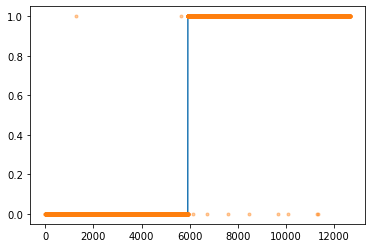

In [713]:
plt.plot(y)
plt.plot(yhat.data,'.',alpha=0.4)

1.  아래의 지침에 따라 200 epoch 학습을 진행하라. 학습이 잘 되는가?

-   손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss()를 사용하지 않고
    수식을 직접 입력할 것.
-   옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것.

In [714]:
torch.manual_seed(12345)
net = torch.nn.Sequential(
    torch.nn.Linear(784,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,1),
    torch.nn.Sigmoid()
)

In [715]:
optimizr = torch.optim.Adam(net.parameters(),lr=0.002)

In [716]:
for epoc in range(200):
    yhat = net(X)
    loss = -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

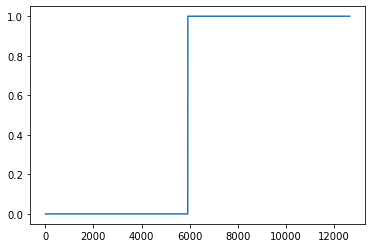

In [717]:
plt.plot(y)
plt.plot(yhat.data,'.',alpha=0.4)

In [718]:
yhat.data

tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]])

학습이 잘 되지 않았다.

1.  아래의 지침에 따라 200 epoch 학습을 진행하라. 학습이 잘 되는가?

-   이미지의 값을 0과 1사이로 규격화 하라. (Xnp = Xnp/255 를
    이용하세요!)
-   손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss()를 사용하지 않고
    수식을 직접 입력할 것.
-   옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것.

In [719]:
X = X/255

In [720]:
torch.manual_seed(12345)
net = torch.nn.Sequential(
    torch.nn.Linear(784,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,1),
    torch.nn.Sigmoid()
)

In [721]:
optimizr=torch.optim.Adam(net.parameters(),lr=0.002)

In [722]:
for epoc in range(200):
    yhat = net(X)
    loss = -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

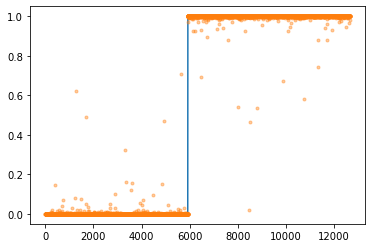

In [723]:
plt.plot(y)
plt.plot(yhat.data,'.',alpha=0.4)

1.  아래와 같은 수식을 이용하여 accuracy를 계산하라.

$\text{accuracy}=\frac{1}{n}\sum_{i=1}^n I(\tilde{y}_i=y_i)$ -
$\tilde{y}_i = \begin{cases}  1 & \hat{y}_i > 0.5 \\  0 & \hat{y}_i \leq 0.5 \end{cases}$ -
$I(\tilde{y}_i=y_i) = \begin{cases} 1 & \tilde{y}_i=y_i \\ 0 & \tilde{y}_i \neq y_i \end{cases}$

단, $n$은 0과 1을 의미하는 이미지의 수

In [724]:
ytilde = (yhat > 0.5) * 1

In [725]:
ytilde

tensor([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]])

In [726]:
(ytilde == y) * 1

tensor([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]])

In [727]:
torch.sum((ytilde == y) * 1)

tensor(12661)

In [728]:
torch.sum((ytilde == y) * 1)/len(y)

tensor(0.9997)

In [730]:
print("accuraccy: ",torch.sum((ytilde == y) * 1)/len(y))

accuraccy:  tensor(0.9997)

In [731]:
print("accuracy: ",((yhat>0.5) == y).sum() / len(y))

accuracy:  tensor(0.9997)

------------------------------------------------------------------------